# Covid-19 Forecasting and Analysis

This notebook uses plotly which is not rendered on GitHub. To view the choropleth plots in the notebook please use Jupyter Notebook Viewer and give it a moment to load.

Link: https://nbviewer.jupyter.org/github/ZacharyJWyman/Covid-19-/blob/master/notebooks/Covid-19%20Visualization%20and%20Analysis%20.ipynb

# References

### Data:

https://github.com/nytimes/covid-19-data

https://www.infoplease.com/us/states/state-population-by-rank

https://facebook.github.io/prophet/

In [1]:
#import required libraries.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import plotly.express as px
from datetime import datetime as dt
from datetime import timedelta
from pytrends.request import TrendReq
from fbprophet import Prophet

# Cases: Confirmed, Deaths and Recovered

In [2]:
#get cases and deaths data.
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
data = pd.read_csv(url, error_bad_lines = False)
data.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [3]:
#write csv to folder for usability in kaggle. 
data.to_csv(r'C:\Users\19712\Desktop\Data Science\Covid\Kaggle\covid.csv')

In [4]:
#get and clean recovery data to be usable.
url_rec = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(url_rec, error_bad_lines = False)
recovered.drop(['Lat', 'Long', 'Province/State'], axis = 1, inplace = True)

recovered = recovered[recovered['Country/Region'] == 'US'].T
recovered = recovered[1:]
recovered.columns = ['Recovered']
recovered = recovered['Recovered'].astype('int64')

In [5]:
#write csv to folder for usability in kaggle.
recovered.to_csv(r'C:\Users\19712\Desktop\Data Science\Covid\Kaggle\recovered.csv')

In [6]:
cases = data[['date', 'state', 'cases', 'deaths']]

In [7]:
#For sake of choro map we need to abbreviate choromap.
us_states = {
        'Alaska': 'AK',
        'Alabama': 'AL',
        'Arkansas': 'AR',
        'American Somoa': 'AS',
        'Arizona': 'AZ',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Colombia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Iowa': 'IA',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Massachusetts': 'MA',
        'Maryland': 'MD',
        'Maine': 'ME',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Missouri': 'MO',
        'Mississippi': 'MS',
        'Montana': 'MT',
        'National': 'NA',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Nebraska': 'NE',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'Nevada': 'NV',
        'New York': 'NY',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Virginia': 'VA',
        'Virgin Islands': 'VI',
        'Vermont': 'VT',
        'Washington': 'WA',
        'Wisconsin': 'WI',
        'West Virginia': 'WV',
        'Wyoming': 'WY'
}

In [8]:
cases['abbrev'] = cases['state'].map(us_states).fillna(cases['state'])
cases

date          state  cases  deaths abbrev
0     2020-01-21     Washington      1       0     WA
1     2020-01-22     Washington      1       0     WA
2     2020-01-23     Washington      1       0     WA
3     2020-01-24       Illinois      1       0     IL
4     2020-01-24     Washington      1       0     WA
...          ...            ...    ...     ...    ...
8754  2020-08-08       Virginia  99189    2322     VA
8755  2020-08-08     Washington  64347    1752     WA
8756  2020-08-08  West Virginia   7563     131     WV
8757  2020-08-08      Wisconsin  64231    1007     WI
8758  2020-08-08        Wyoming   3013      28     WY

[8759 rows x 5 columns]

Great, we have added abbreviations to the dataframe. We will keep the state name for ease of use when merging another dataframe. Now we can plot a geographical visual that tells us the prevalence of cases in each state over a certain time period.

In [9]:
fig = px.choropleth(cases,
                   locations='abbrev',
                   color='cases',
                   hover_name = 'abbrev',
                   locationmode = 'USA-states',
                   animation_frame = 'date')

fig.update_layout(
title_text = 'Spread of Covid-19 in the United States',
title_x = 0.5,
geo_scope = 'usa',
geo=dict(
showframe = False,
showcoastlines = False))

fig.show()

We can see the severity of cases as the virus spreads across the United States with the above visual. However, a more helpful statistic will be to measure the virus spread versus the population for each state. Then we can get a more accurate estimate of the significance it holds in each state. 

In [10]:
#importing population data.
pop_data = pd.read_csv(r"C:\Users\19712\Documents\Python Scripts\population estimates.txt", sep = '\t', thousands = ',', header = int())
pop_data.columns = ['rank', 'state', 'population', 'percent of Tot']
pop_data.drop(['percent of Tot', 'rank'] , axis=1, inplace=True)

In [11]:
#write csv to folder for usability in kaggle.
pop_data.to_csv(r'C:\Users\19712\Desktop\Data Science\Covid\Kaggle\pop_data.csv')

In [12]:
#merge population to dataframe.
cases = cases.merge(pop_data,
          how = 'left',
          left_on = 'state',
          right_on = 'state')
cases

date          state  cases  deaths abbrev  population
0     2020-01-21     Washington      1       0     WA   7614893.0
1     2020-01-22     Washington      1       0     WA   7614893.0
2     2020-01-23     Washington      1       0     WA   7614893.0
3     2020-01-24       Illinois      1       0     IL  12671821.0
4     2020-01-24     Washington      1       0     WA   7614893.0
...          ...            ...    ...     ...    ...         ...
8754  2020-08-08       Virginia  99189    2322     VA   8535519.0
8755  2020-08-08     Washington  64347    1752     WA   7614893.0
8756  2020-08-08  West Virginia   7563     131     WV   1792147.0
8757  2020-08-08      Wisconsin  64231    1007     WI   5822434.0
8758  2020-08-08        Wyoming   3013      28     WY    578759.0

[8759 rows x 6 columns]

Now that we have a more complete dataframe we will create another visual to account for the severity of cases in each state. To do this we will use the same as above for simplicity. First, we must determine a rolling percentage of cases in each state so that we can determine the severity of the virus. 

In [13]:
#creating percentage column in dataframe.
cases['percent'] = cases['cases'] / cases['population'] * 100

In [14]:
fig = px.choropleth(cases,
                   locations='abbrev',
                   color='percent',
                   hover_name = 'abbrev',
                   locationmode = 'USA-states',
                   animation_frame = 'date')

fig.update_layout(
title_text = 'Spread of Covid-19 in the United States (%)',
title_x = 0.5,
geo_scope = 'usa',
geo=dict(
showframe = False,
showcoastlines = False))

fig.show()

In recent months, the percent of population with the virus has increased dramatically. Some states now have over the 2.5% threshold. Yet, New York has managed to minimize the amount of cases despite having a surge of cases early on in the virus.

In [15]:
sorted_cases = cases.sort_values('cases', ascending=False)
state_max_cases = sorted_cases.drop_duplicates('state')
state_max_cases.drop('abbrev', axis=1, inplace=True)

In [16]:
#top 10 states with most cases.
cases_top10 = state_max_cases.nlargest(10, 'cases')

#top 10 states with highest severity of cases.
percent_top10 = state_max_cases.nlargest(10, 'percent')

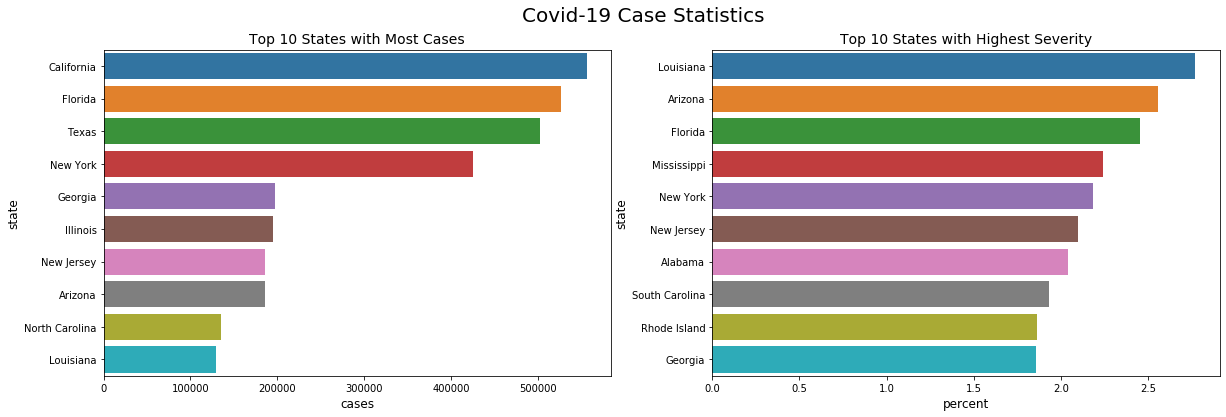

In [17]:
fig, axes = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (20,6))
fig.suptitle("Covid-19 Case Statistics", fontsize = 20)
axes[0].set_title('Top 10 States with Most Cases', fontsize = 14)
axes[0].set_xlabel('cases', fontsize = 12)
axes[0].set_ylabel('state', fontsize = 12)
axes[1].set_title('Top 10 States with Highest Severity', fontsize = 14)
axes[1].set_xlabel('percent', fontsize = 12)
axes[1].set_ylabel('state', fontsize = 12)

sns.barplot(ax = axes[0], data = cases_top10, 
            y = 'state', 
            x = 'cases')

sns.barplot(ax = axes[1], data = percent_top10, 
            y = 'state', 
            x = 'percent')

Text(0.5, 1.0, 'Statewide Covid-19 Cases')

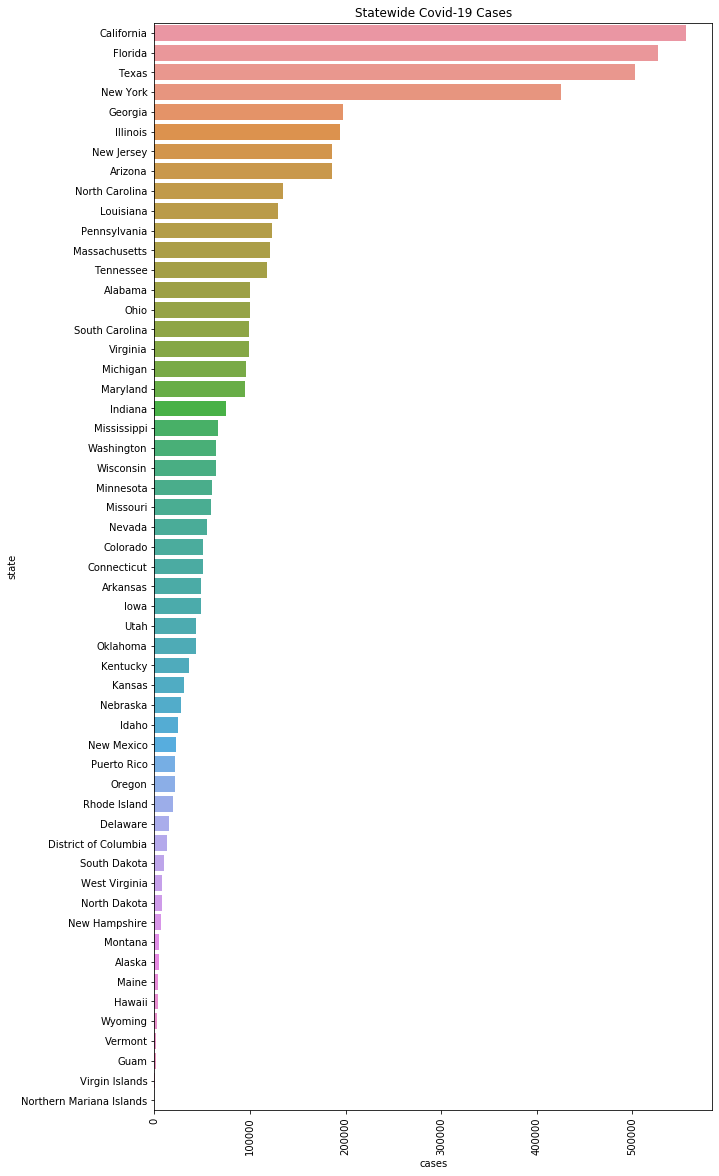

In [18]:
#add countplot.
fig, ax = plt.subplots(ncols=1, sharey = False, figsize = (10,20))
plt.xticks(rotation=90)
sns.barplot(y = state_max_cases['state'], x = state_max_cases['cases']).set_title('Statewide Covid-19 Cases')

In [19]:
#death rate.
percent_deaths = cases['deaths'] / cases['population'] * 100
cases['death rate'] = percent_deaths

In [20]:
#choro map
fig = px.choropleth(cases,
                   locations='abbrev',
                   color='deaths',
                   hover_name = 'abbrev',
                   locationmode = 'USA-states',
                   animation_frame = 'date')

fig.update_layout(
title_text = 'Covid-19 Deaths in the United States',
title_x = 0.5,
geo_scope = 'usa',
geo=dict(
showframe = False,
showcoastlines = False))

fig.show()

In [21]:
fig = px.choropleth(cases,
                   locations='abbrev',
                   color='death rate',
                   hover_name = 'abbrev',
                   locationmode = 'USA-states',
                   animation_frame = 'date')

fig.update_layout(
title_text = 'Covid-19 Death Rate in the United States',
title_x = 0.5,
geo_scope = 'usa',
geo=dict(
showframe = False,
showcoastlines = False))

fig.show()

In [22]:
sorted_deaths = cases.sort_values('deaths', ascending = False)
state_max_deaths = sorted_deaths.drop_duplicates('state')
state_max_deaths.drop('abbrev', axis=1, inplace=True)

In [23]:
#top 10 states with most deaths.
deaths_top10 = state_max_deaths.nlargest(10, 'deaths')

#top 10 states with highest death rate.
death_ratetop10 = state_max_deaths.nlargest(10, 'death rate')

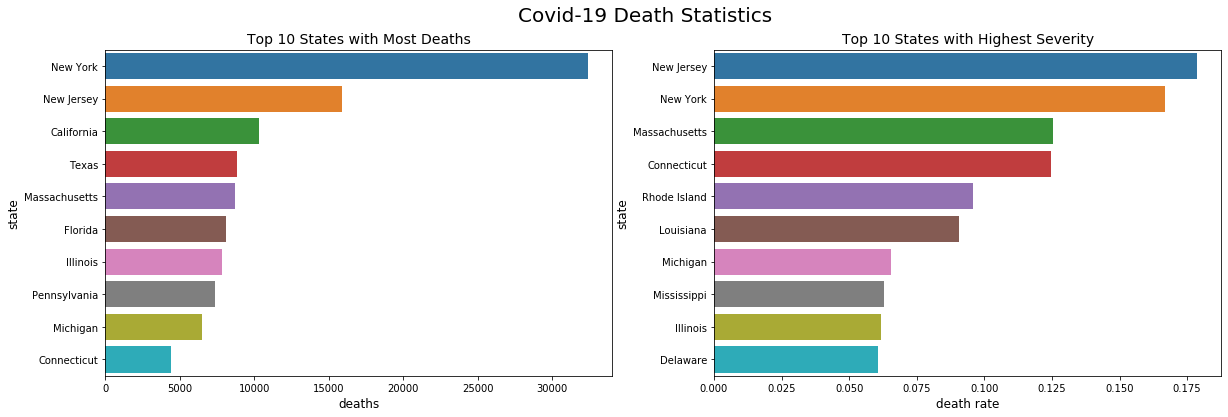

In [24]:
fig, axes = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (20,6))
fig.suptitle("Covid-19 Death Statistics", fontsize = 20)
axes[0].set_title('Top 10 States with Most Deaths', fontsize = 14)
axes[0].set_xlabel('cases', fontsize = 12)
axes[0].set_ylabel('state', fontsize = 12)
axes[1].set_title('Top 10 States with Highest Severity', fontsize = 14)
axes[1].set_xlabel('percent', fontsize = 12)
axes[1].set_ylabel('state', fontsize = 12)

sns.barplot(ax = axes[0], data = deaths_top10, 
            y = 'state', 
            x = 'deaths')

sns.barplot(ax = axes[1], data = death_ratetop10, 
            y = 'state', 
            x = 'death rate')

Text(0.5, 1.0, 'Statewide Covid-19 Deaths')

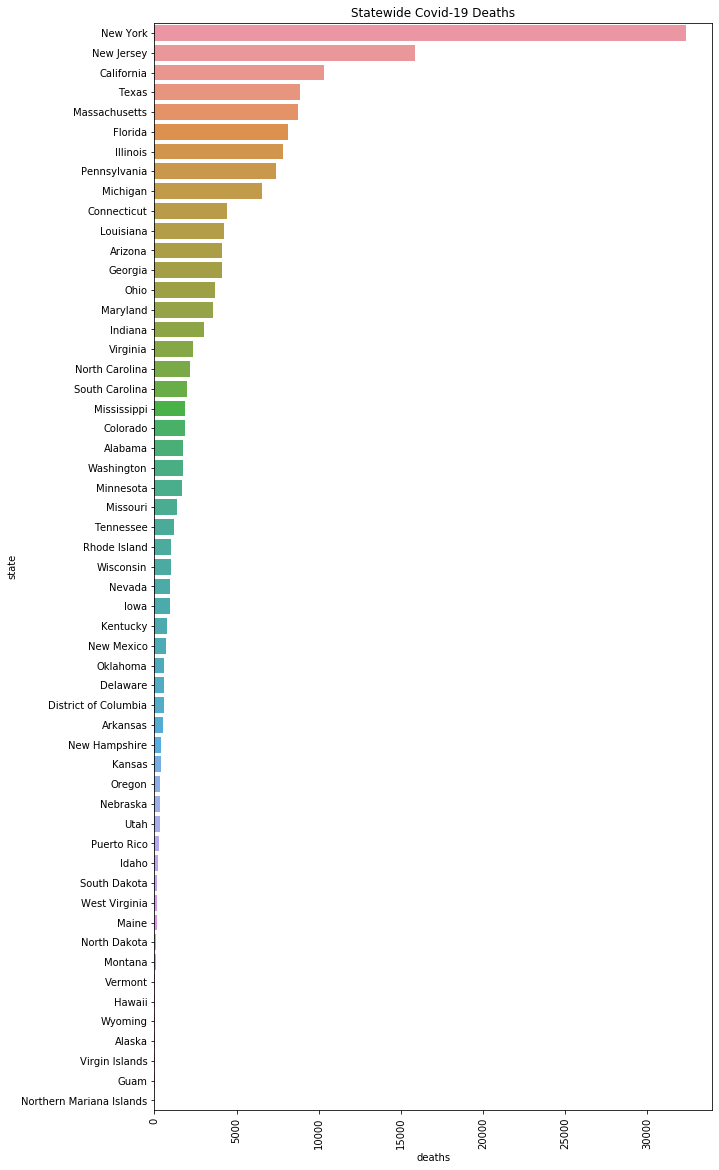

In [25]:
#add countplot. 
fig, ax = plt.subplots(ncols=1, sharey = False, figsize = (10,20))
plt.xticks(rotation=90)
sortedDeaths = state_max_cases.sort_values(by = ['deaths'], ascending = False)
sns.barplot(y = sortedDeaths['state'], x = sortedDeaths['deaths']).set_title('Statewide Covid-19 Deaths')

In [26]:
date_deaths = data[['date', 'deaths']]
deaths_by_date = date_deaths.groupby('date')['deaths'].sum()

date_cases = data[['date', 'cases']]
cases_by_date = date_cases.groupby('date')['cases'].sum()

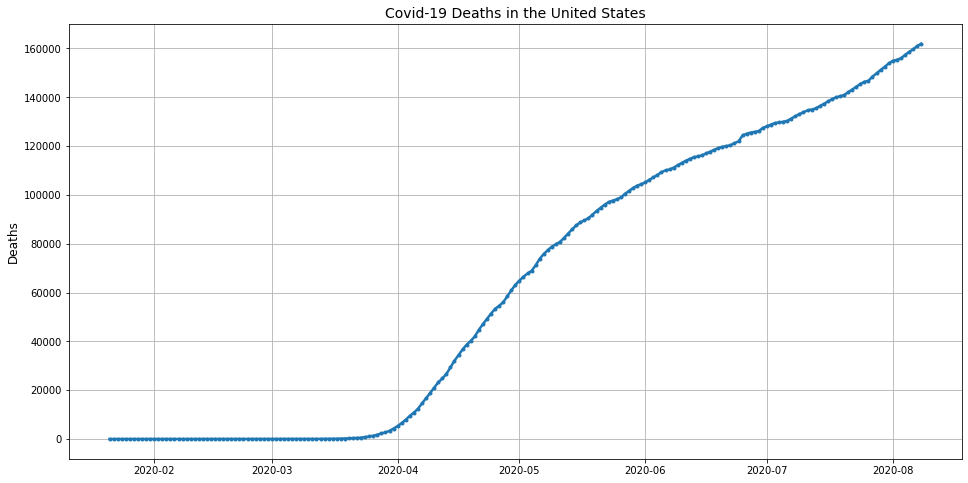

In [27]:
deaths_by_date.index = pd.to_datetime(deaths_by_date.index)
months = mdates.MonthLocator()

#plot deaths over time.
fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 3)
ax.plot(deaths_by_date, **marker_style)
plt.ylabel("Deaths", fontsize = 12)
plt.title('Covid-19 Deaths in the United States', fontsize = 14)

#format ticks
ax.xaxis.set_major_locator(months)
ax.grid(True)

plt.show()

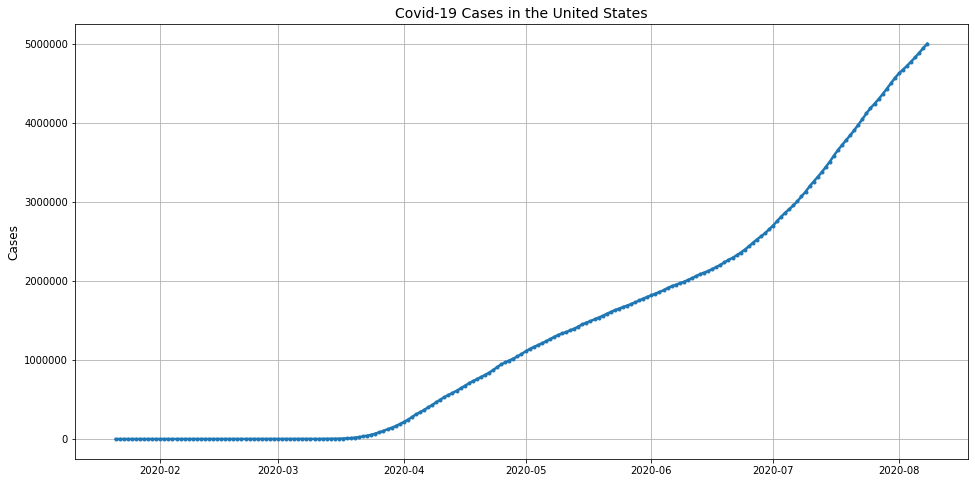

In [28]:
cases_by_date.index = pd.to_datetime(cases_by_date.index)

#plot cases over time.
fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 3)
ax.plot(cases_by_date, **marker_style)
plt.ylabel('Cases', fontsize = 12)
plt.title('Covid-19 Cases in the United States', fontsize = 14)

#formatting 
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

plt.show()

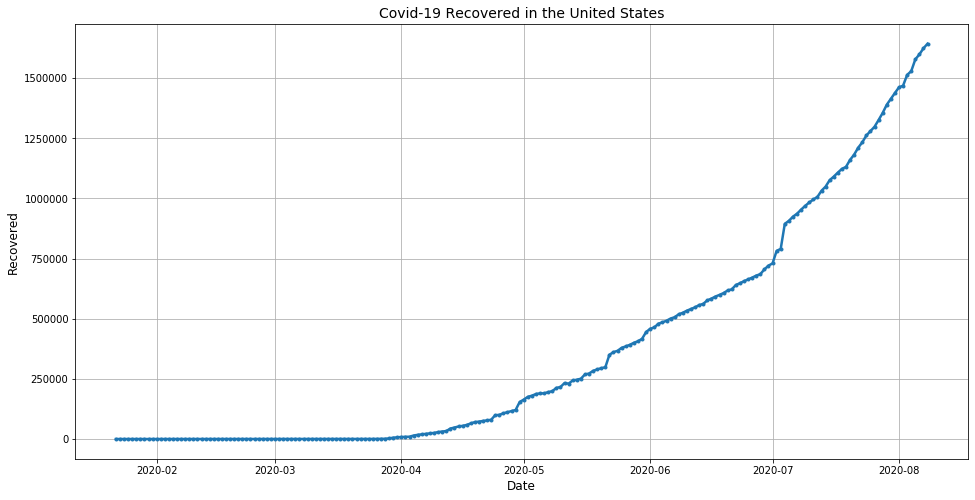

In [29]:
recovered_by_date = pd.DataFrame(recovered)
recovered_by_date.index = pd.to_datetime(recovered_by_date.index)

#plot cases over time.
fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 3)
ax.plot(recovered_by_date, **marker_style)
plt.ylabel('Recovered', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Covid-19 Recovered in the United States', fontsize = 14)

#formatting 
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

plt.show()

In [30]:
#create cleaned dataframe for plot.
recovered.index = pd.to_datetime(recovered.index)
plot_df = pd.DataFrame(cases_by_date)


labels = ['deaths', 'recovered']
dfs = [deaths_by_date, recovered]
i=0
for label in labels:
    plot_df[label] = pd.DataFrame(dfs[i])
    i+=1
plot_df

cases  deaths  recovered
date                                  
2020-01-21        1       0        NaN
2020-01-22        1       0        0.0
2020-01-23        1       0        0.0
2020-01-24        2       0        0.0
2020-01-25        3       0        0.0
...             ...     ...        ...
2020-08-04  4778669  157299  1528979.0
2020-08-05  4832395  158552  1577851.0
2020-08-06  4889733  159623  1598624.0
2020-08-07  4950708  160977  1623870.0
2020-08-08  5005904  161942  1643118.0

[201 rows x 3 columns]

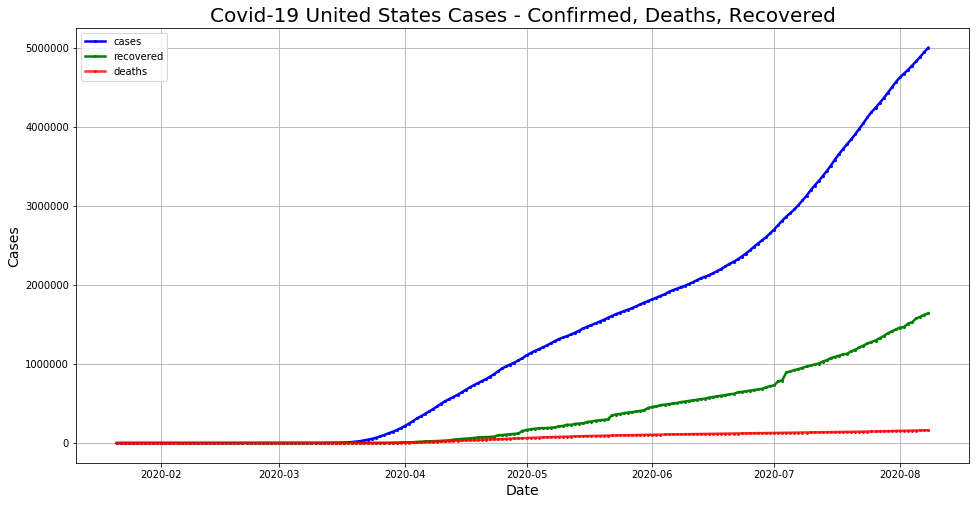

In [31]:
#plot.
fig, ax = plt.subplots(1, figsize = (16,8))

plt.plot(plot_df['cases'], label = 'cases', color = 'blue', linewidth = 2.5, marker = 'o', markersize = 2)
plt.plot(plot_df['recovered'], label = 'recovered', color = 'green', linewidth = 2.5, marker = 'o', markersize = 2)
plt.plot(plot_df['deaths'], label = 'deaths', color = 'red', linewidth = 2.5, marker = 'o', markersize = 2, alpha = 0.8)


#labels
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Cases', fontsize = 14)
plt.title('Covid-19 United States Cases - Confirmed, Deaths, Recovered', fontsize = 20)
plt.legend()

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)
#ax.patch.set_facecolor('grey')
#ax.patch.set_alpha(0.2)

#bar plot with heat register on side for confirmed cases, deaths, and recovered. Maybe?  Blue, Green, Red

In [32]:
#states affected over time. 
states_affected = []
cases_date = cases[['cases', 'date','state']]
for i, row in cases_date.iterrows():
    if row['cases'] != 0:
        states_affected.append(row)
states_affected = pd.DataFrame(states_affected)

In [33]:
#first 10 States to contract covid-19. 
sorted_dates = states_affected.sort_values('date', ascending = True)
sorted_uniq_dates = sorted_dates.drop_duplicates('state')
sorted_uniq_dates.head(10)

cases        date          state
0        1  2020-01-21     Washington
3        1  2020-01-24       Illinois
5        1  2020-01-25     California
8        1  2020-01-26        Arizona
35       1  2020-02-01  Massachusetts
57       1  2020-02-05      Wisconsin
98       1  2020-02-12          Texas
133     10  2020-02-17       Nebraska
199      1  2020-02-25           Utah
225      1  2020-02-28         Oregon

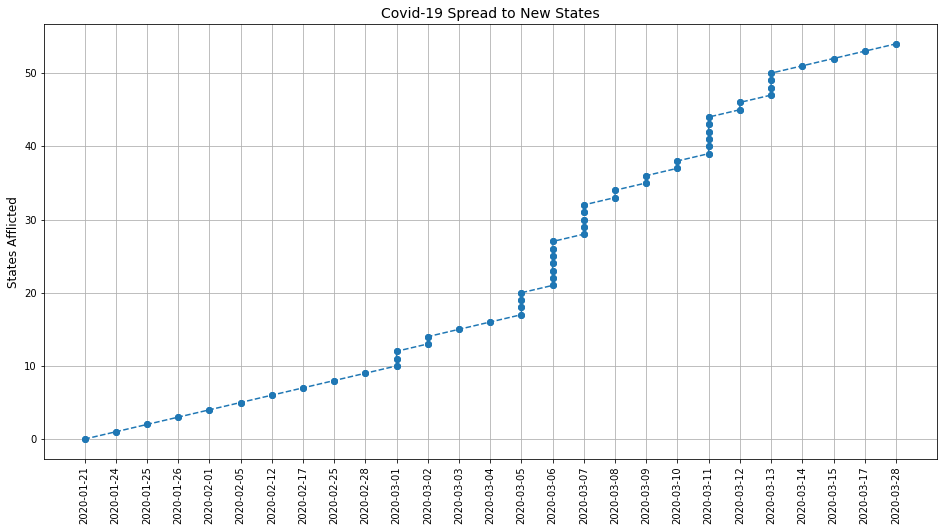

In [34]:
#spread of Covid-19 to New States.
state_counts = []
for i in range(0, len(sorted_uniq_dates)):
    state_counts.append(i)

sorted_uniq_dates['count'] = state_counts

plt.figure(figsize = (16,8))
plt.scatter(x = sorted_uniq_dates['date'], y = sorted_uniq_dates['count'])
plt.plot(sorted_uniq_dates['date'], sorted_uniq_dates['count'], 'o--')
plt.xticks(rotation=90)
plt.title('Covid-19 Spread to New States', fontsize = 14)
plt.ylabel('States Afflicted', fontsize = 12)
plt.grid(True)

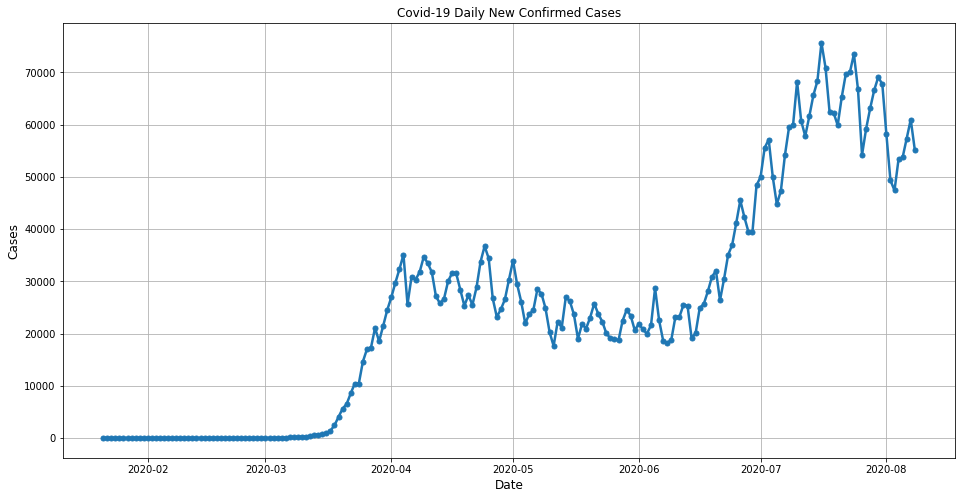

In [35]:
cases_by_date.index = pd.to_datetime(cases_by_date.index)

#covid-19 daily new confirmed cases.
difference = cases_by_date.diff()
difference = difference.fillna(0)
fig, ax = plt.subplots(figsize = (16,8))

marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(difference, **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cases', fontsize = 12)
plt.title('Covid-19 Daily New Confirmed Cases')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

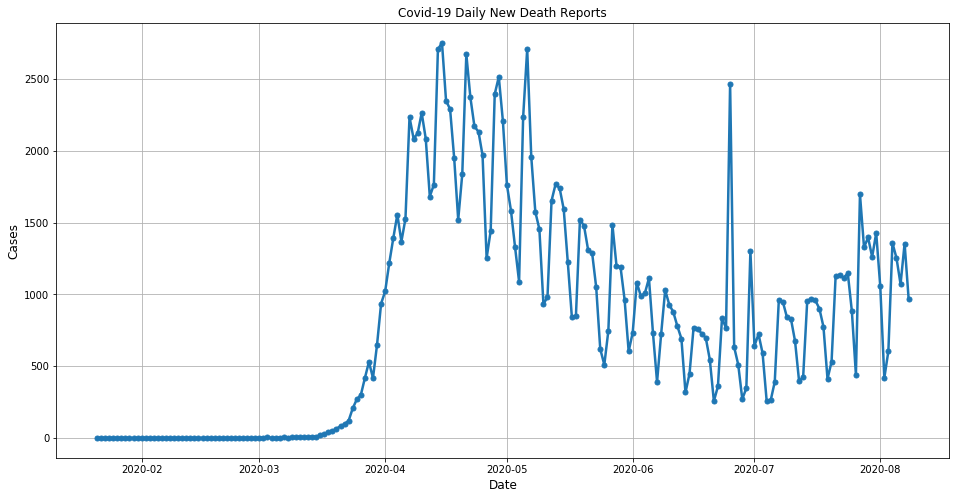

In [36]:
#covid-19 daily new deaths reported.
difference = deaths_by_date.diff()
difference = difference.fillna(0)
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(difference, **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cases', fontsize = 12)
plt.title('Covid-19 Daily New Death Reports')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

# Claim: Covid-19 hitting largely Democratic States harder than Republican

There has been a lot of critisicm over the claims that democratic states are not handling Covid-19 as well as Republican. In this section we will examine statistics looking at case rate by political affiliation.

In [37]:
#prepare data.
data = data.merge(pop_data,
          how = 'left',
          left_on = 'state',
          right_on = 'state')

In [38]:
democratic = ['Washington', 'Oregon', 'Nevada', 'California', 'Colorado', 'New Mexico', 'Illinois', 'Minnesota', 'Virginia',
             'Maine', 'New York', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Jersey',
             'Deleware', 'Maryland', 'Washington D.C.', 'Hawaii']

republican = ['Idaho', 'Montana', 'Utah', 'Arizona', 'Wyoming' ,'Texas', 'North Dakota', 'South Dakota', 'Nebraska',
             'Kansas', 'Oklahoma', 'Iowa', 'Missouri', 'Arkansas', 'Lousiana', 'Wisconsin' ,'Michigan', 'Indiana', 'Kentucky',
             'Tennessee', 'Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Ohio', 'West Virgina',
             'Pennsylvania', 'Alaska']

#initialize empty column.
data['political status'] = np.nan

#create dummy variables.
for i, state in enumerate(data['state']):
    if state in democratic:
        data.at[i,'political status'] = 0
    else:
        data.at[i, 'political status'] = 1

In [39]:
#percents
democratic_cases = data[data['political status'] == 0]['cases'].sum() 
republican_cases = data[data['political status'] == 1]['cases'].sum()

democratic_pop = data[data['political status'] == 0]['population'].sum()
republican_pop = data[data['political status'] == 1]['population'].sum()

democratic_case_percent = democratic_cases / democratic_pop * 100
republican_case_percent = republican_cases / republican_pop * 100

political_affiliation = pd.DataFrame({'Democratic': [democratic_case_percent],
                                     'Republican': [republican_case_percent]})
political_affiliation

Democratic  Republican
0    0.600954    0.437555

Therefore, Democratic states do have a higher percentage in virus cases compared to Republican states. 

Keep in mind that this statistic has a lot of variance and not a lot of analysis can be derived from it. Certain states are more urbanized while others are largely rural. The virus spreads from clustering, which will be more devestating in urban areas. We must also address the fact that the BLM movement is spreading across the country and certain affiliations have been proven to be more invested in these movements, involving protests and gatherings. These gatherings are hotspots for spread of Covid-19 if people are not following the safety guidelines. 

# Testing in the United States

In [40]:
#coronavirus testing. 
data_owid = pd.read_csv(r"D:\Data Science\Covid\datasets\owid-covid-data.csv")
united_states = data_owid['location'] == 'United States'
us_df = data_owid[united_states]
testing = us_df[['date', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'positive_rate', 'tests_per_case']]
testing = testing.fillna(0)

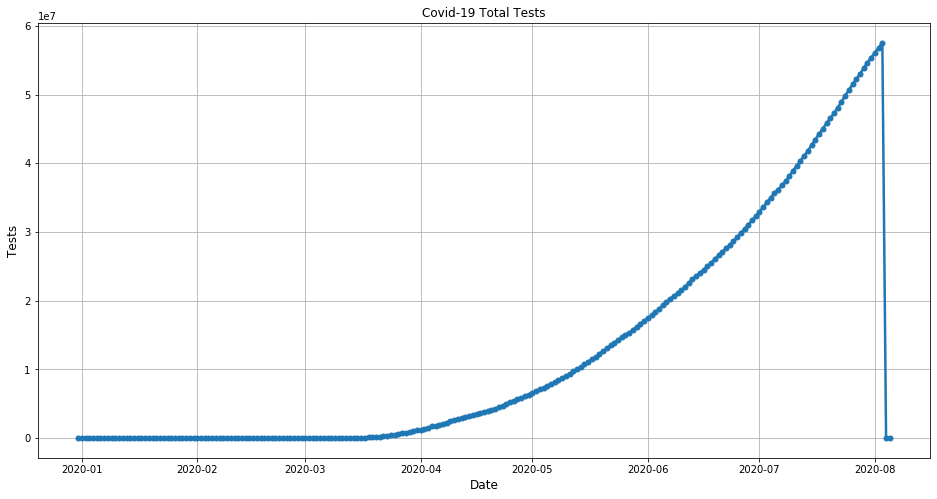

In [41]:
testing['date'] = pd.to_datetime(testing['date'])

fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['total_tests'], **marker_style)

#Labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Tests', fontsize = 12)
plt.title('Covid-19 Total Tests')

#Formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

#To do: supress scientific notation.

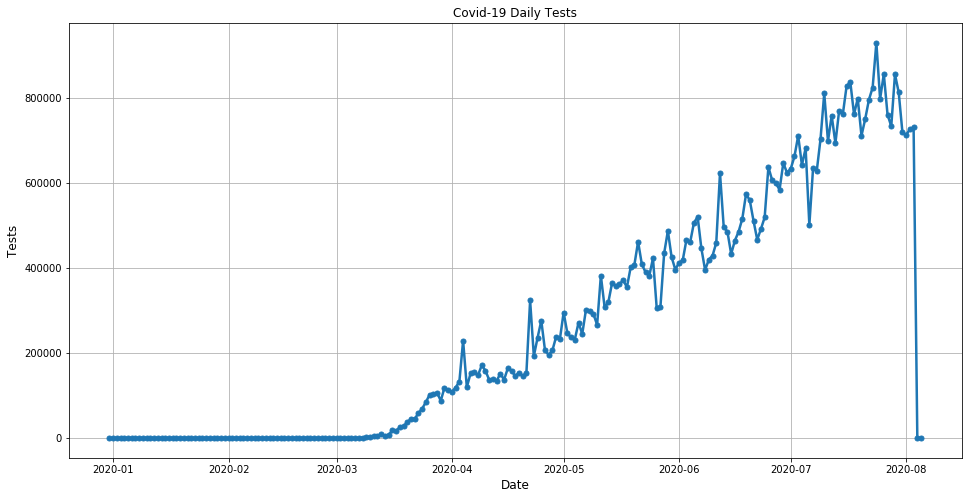

In [42]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['new_tests'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Tests', fontsize = 12)
plt.title('Covid-19 Daily Tests')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

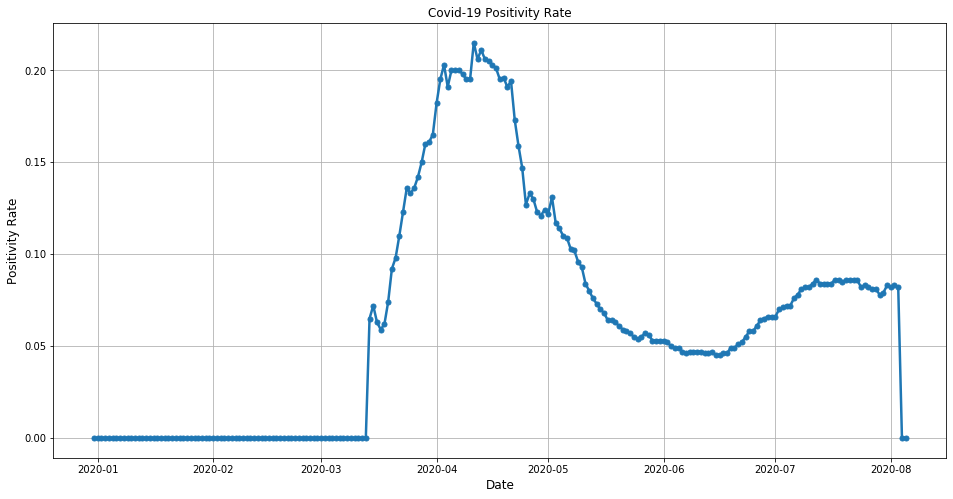

In [43]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['positive_rate'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Positivity Rate', fontsize = 12)
plt.title('Covid-19 Positivity Rate')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

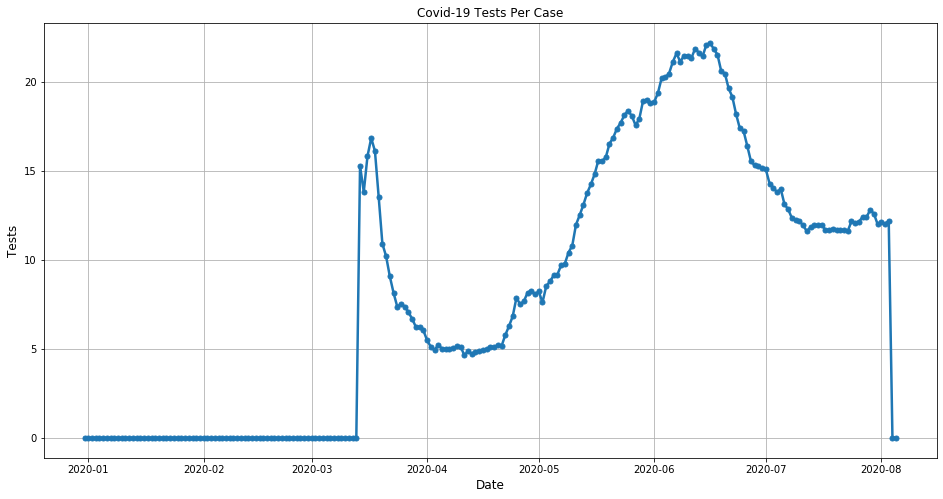

In [44]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['tests_per_case'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Tests', fontsize = 12)
plt.title('Covid-19 Tests Per Case')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

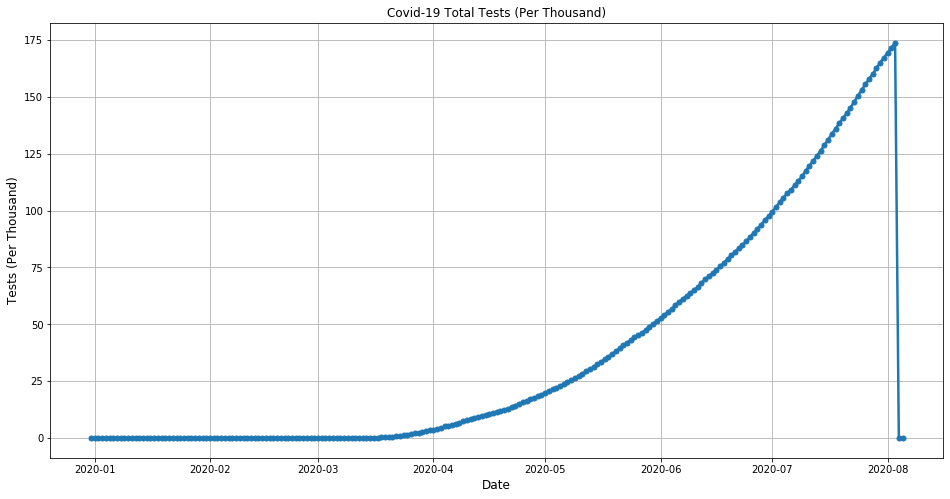

In [45]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['total_tests_per_thousand'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Tests (Per Thousand)', fontsize = 12)
plt.title('Covid-19 Total Tests (Per Thousand)')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

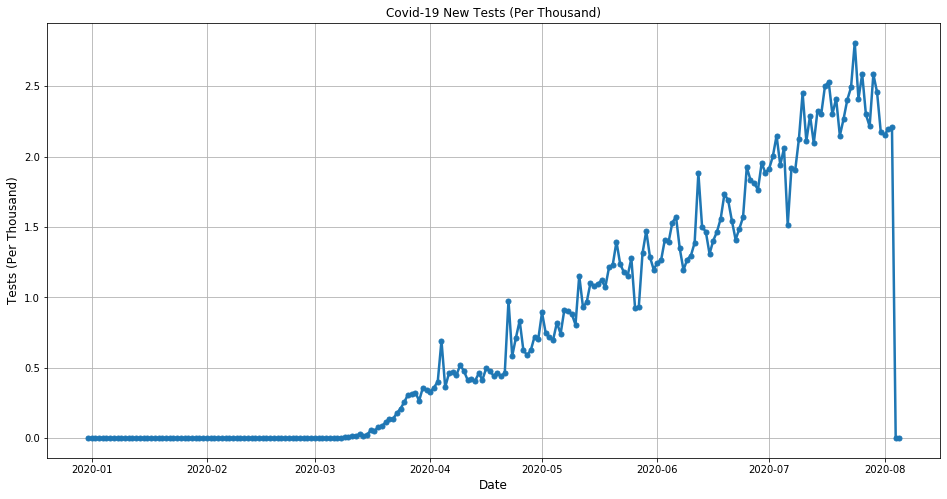

In [46]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(testing['date'], testing['new_tests_per_thousand'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Tests (Per Thousand)', fontsize = 12)
plt.title('Covid-19 New Tests (Per Thousand)')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

# Covid-19 Search Trends

In this section we will examine search trends of 

In [47]:
#coronavirus search trends using google trends API with pytrend. 
pytrends = TrendReq()

kw_list = ['Coronavirus']
pytrends.build_payload(kw_list, cat = 0, geo = 'US', timeframe = '2019-12-01 2020-08-04', gprop='')


covid_search_trends = pytrends.interest_over_time()
covid_search_trends = covid_search_trends.reset_index()
covid_search_trends = covid_search_trends.drop(['isPartial'], axis=1)
covid_search_trends

date  Coronavirus
0   2019-12-01            0
1   2019-12-02            0
2   2019-12-03            0
3   2019-12-04            0
4   2019-12-05            0
..         ...          ...
243 2020-07-31            7
244 2020-08-01            6
245 2020-08-02            6
246 2020-08-03            7
247 2020-08-04            6

[248 rows x 2 columns]

In [48]:
#convert into plottable datatypes.
covid_search_trends.index = pd.to_datetime(covid_search_trends.index)
covid_search_trends['Coronavirus'] = covid_search_trends['Coronavirus'].astype('int64')
covid_search_trends['date'] = pd.to_datetime(covid_search_trends['date'])

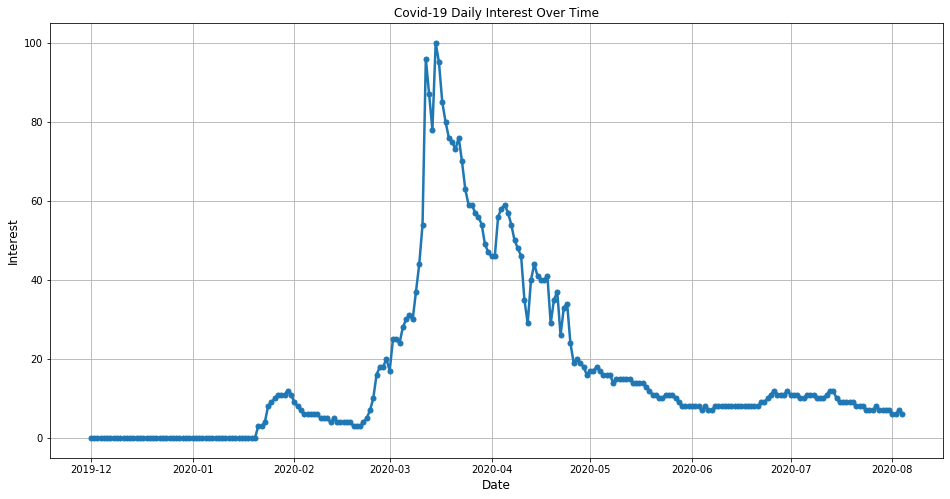

In [49]:
fig, ax = plt.subplots(figsize = (16,8))


marker_style = dict(linewidth=2.5, linestyle = '-', marker = 'o', markersize = 5)
ax.plot(covid_search_trends['date'], covid_search_trends['Coronavirus'], **marker_style)

#labels
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Interest', fontsize = 12)
plt.title('Covid-19 Daily Interest Over Time')

#formatting
ax.xaxis.set_major_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  
ax.grid(True)

# Predictive Modeling

## Prophet

We will be using the open source software Prophet to forecast future Covid-19 cases. It provides reliable predictions as it is robust to shifts in the data and handles outliers. Our model for forecasting confirmed cases, deaths and recovered patients will be relatively straightforward as the data follows a polynomial trend.

## Cases

In [50]:
confirmed = pd.DataFrame(cases_by_date)

In [51]:
confirmed.tail()

cases
date               
2020-08-04  4778669
2020-08-05  4832395
2020-08-06  4889733
2020-08-07  4950708
2020-08-08  5005904

In [52]:
#clean dataframe for usability with prophet.
confirmed.reset_index(level=0, inplace=True)
confirmed.columns = ['ds', 'y']

In [53]:
#setting up the model to predict 10 days ahead.
model = Prophet(interval_width = 0.95)
model.fit(confirmed)
future = model.make_future_dataframe(periods=10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
#predicting future forecast with date.
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper
201 2020-08-09  5.088343e+06  5.057450e+06  5.116013e+06
202 2020-08-10  5.147127e+06  5.120098e+06  5.175768e+06
203 2020-08-11  5.207677e+06  5.180781e+06  5.237455e+06
204 2020-08-12  5.269372e+06  5.238184e+06  5.298603e+06
205 2020-08-13  5.332550e+06  5.298801e+06  5.368487e+06
206 2020-08-14  5.396996e+06  5.361996e+06  5.438139e+06
207 2020-08-15  5.459263e+06  5.418366e+06  5.506753e+06
208 2020-08-16  5.519469e+06  5.471020e+06  5.572896e+06
209 2020-08-17  5.578253e+06  5.521367e+06  5.643506e+06
210 2020-08-18  5.638802e+06  5.575974e+06  5.706164e+06

In the table above, yhat signifies the predicted value while both lower and upper columns refer to the bounds. This is treated as a 95% confidence interval and thus there is 95% certainty that the given value will be between these upper and lower bounds.

In [55]:
pred_cases = forecast[['ds', 'yhat']]
#pred_cases['ds'] = pd.to_datetime(pred_cases['ds'])
pred_cases.set_index('ds', inplace=True)

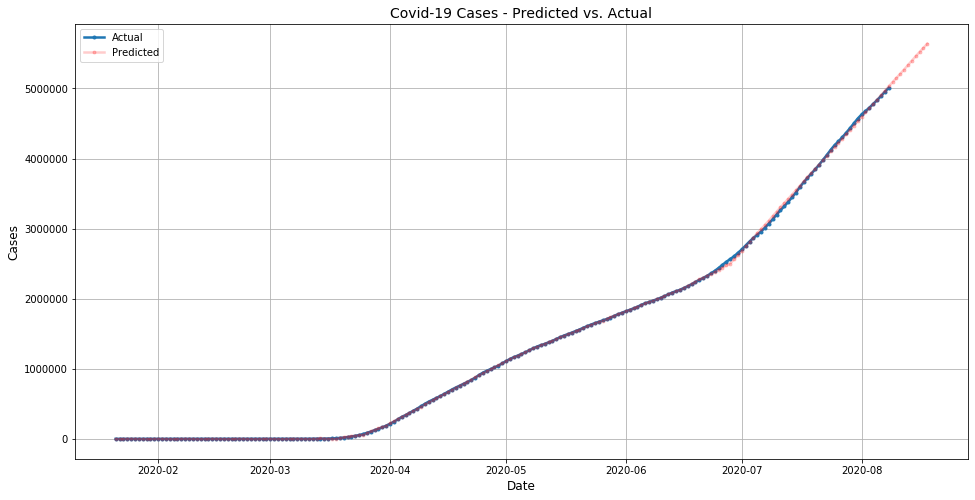

In [56]:
#Prediction plot (cases) + 10 days. 

fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, marker = 'o', markersize = 3)
ax.plot(cases_by_date, **marker_style, linestyle = '-', label = 'Actual')
ax.plot(pred_cases, **marker_style, linestyle = '-', label = 'Predicted', color = 'r', alpha =0.2)
plt.ylabel("Cases", fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Covid-19 Cases - Predicted vs. Actual', fontsize = 14)
ax.legend(loc='upper left')

#ax.patch.set_facecolor('grey')
#ax.patch.set_alpha(0.2)

#Format ticks
ax.xaxis.set_major_locator(months)
ax.grid(True)

plt.show()

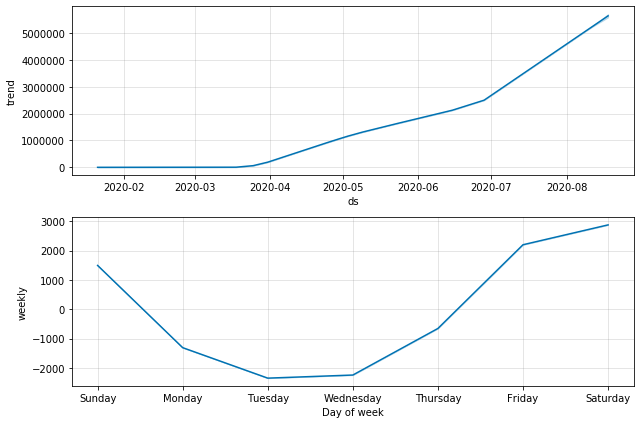

In [57]:
conf_comp_plot = model.plot_components(forecast)

## Deaths

In [58]:
deaths = pd.DataFrame(deaths_by_date)
deaths.reset_index(level=0, inplace=True)
deaths.columns = ['ds', 'y']

In [59]:
model = Prophet(interval_width = 0.95)
model.fit(deaths)
future = model.make_future_dataframe(periods=10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds           yhat     yhat_lower     yhat_upper
201 2020-08-09  160115.048159  158768.369969  161427.186971
202 2020-08-10  160796.208811  159386.081751  162139.902446
203 2020-08-11  161854.528781  160475.270685  163260.041675
204 2020-08-12  162883.470319  161338.723886  164368.220012
205 2020-08-13  163878.508066  162285.884464  165370.177494
206 2020-08-14  164812.168806  162881.031740  166595.533813
207 2020-08-15  165620.637802  163423.521649  167781.026704
208 2020-08-16  166112.794798  163739.810111  168813.020402
209 2020-08-17  166793.955450  163918.727941  169503.809759
210 2020-08-18  167852.275420  164515.316051  171128.938832

In [61]:
pred_deaths = forecast[['ds', 'yhat']]
#pred_cases['ds'] = pd.to_datetime(pred_cases['ds'])
pred_deaths.set_index('ds', inplace=True)

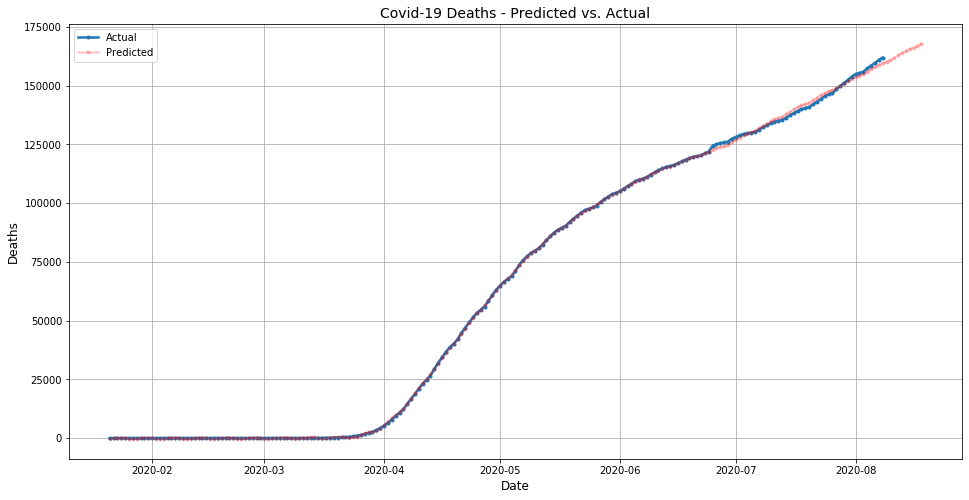

In [62]:
#Prediction plot (deaths) + 10 days. 

fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, marker = 'o', markersize = 3)
ax.plot(deaths_by_date, **marker_style, linestyle = '-', label = 'Actual')
ax.plot(pred_deaths, **marker_style, linestyle = '-', label = 'Predicted', color = 'r', alpha =0.2)
plt.ylabel("Deaths", fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Covid-19 Deaths - Predicted vs. Actual', fontsize = 14)
ax.legend(loc='upper left')

#ax.patch.set_facecolor('grey')
#ax.patch.set_alpha(0.2)

#Format ticks
ax.xaxis.set_major_locator(months)
ax.grid(True)

plt.show()

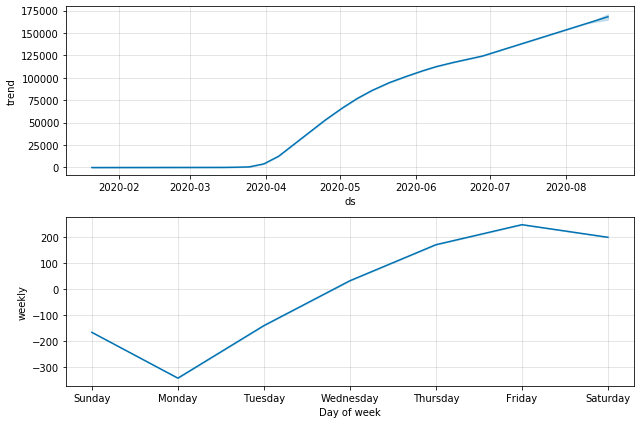

In [63]:
deaths_comp_plot = model.plot_components(forecast)

## Recovered

In [64]:
recovered = pd.DataFrame(recovered)
recovered.reset_index(level=0, inplace=True)
recovered.columns = ['ds', 'y']

In [65]:
model = Prophet(interval_width = 0.95)
model.fit(recovered)
future = model.make_future_dataframe(periods=10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper
200 2020-08-09  1.633256e+06  1.608411e+06  1.659070e+06
201 2020-08-10  1.658130e+06  1.632855e+06  1.682384e+06
202 2020-08-11  1.678121e+06  1.652299e+06  1.703245e+06
203 2020-08-12  1.700756e+06  1.675228e+06  1.725307e+06
204 2020-08-13  1.723078e+06  1.698575e+06  1.748447e+06
205 2020-08-14  1.745755e+06  1.717473e+06  1.770730e+06
206 2020-08-15  1.770442e+06  1.741301e+06  1.797324e+06
207 2020-08-16  1.789009e+06  1.759681e+06  1.817442e+06
208 2020-08-17  1.813883e+06  1.785263e+06  1.846067e+06
209 2020-08-18  1.833874e+06  1.803980e+06  1.865020e+06

In [67]:
pred_recovered = forecast[['ds', 'yhat']]
#pred_cases['ds'] = pd.to_datetime(pred_cases['ds'])
pred_recovered.set_index('ds', inplace=True)

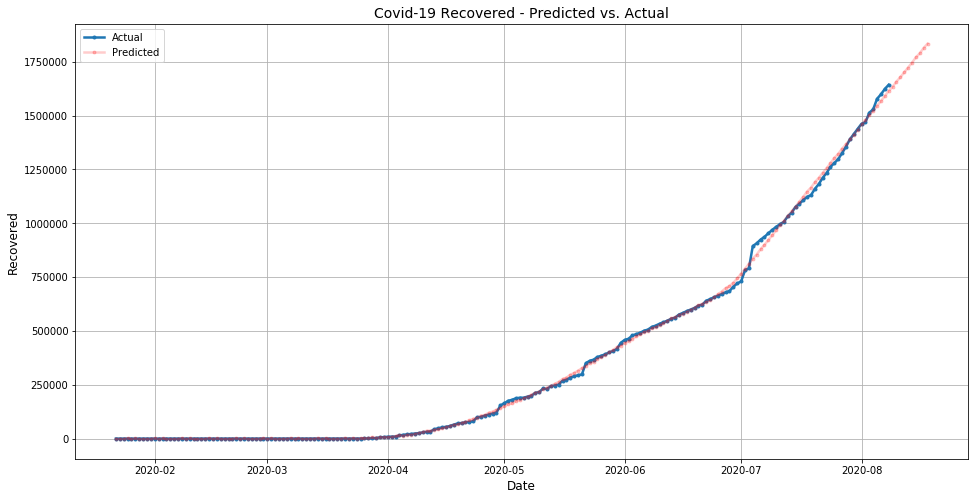

In [68]:
#Prediction plot (deaths) + 10 days. 

fig, ax = plt.subplots(figsize = (16,8))
marker_style = dict(linewidth=2.5, marker = 'o', markersize = 3)
ax.plot(recovered_by_date, **marker_style, linestyle = '-', label = 'Actual')
ax.plot(pred_recovered, **marker_style, linestyle = '-', label = 'Predicted', color = 'r', alpha =0.2)
plt.ylabel("Recovered", fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Covid-19 Recovered - Predicted vs. Actual', fontsize = 14)
ax.legend(loc='upper left')

#ax.patch.set_facecolor('grey')
#ax.patch.set_alpha(0.2)

#Format ticks
ax.xaxis.set_major_locator(months)
ax.grid(True)

plt.show()

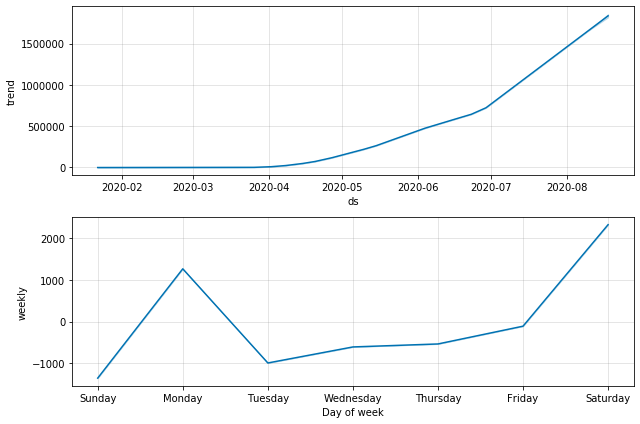

In [69]:
recovered_comp_plot = model.plot_components(forecast)